# This script will describe the creation of the first dataset

In [1]:
import pandas as pd
from rdkit import Chem
#The starting point is this dataframe found on the harddrive of ShuZe Wang, who started the project
df_original = pd.read_csv('/localhome/cschiebroek/ShuZe/vp/data cleaning/cleaned_vp_all.tsv', sep='\t')
#This dataframe can still be found on the harddrive, as well as on Euler in Shuze's work directory
print("Original amount of datapoints: ", len(df_original))
print(df_original['Temperature'].value_counts())   
#As we see. this dataframe has 4436 datapoints, most of which (3098) have a temperature of 298.15K
df_original_298 = df_original[df_original['Temperature'] == 298.15] 
print("Amount of datapoints with temperature 298.15K: ", len(df_original_298))

Original amount of datapoints:  4436
Temperature
298.15    3098
293.15    1338
Name: count, dtype: int64
Amount of datapoints with temperature 298.15K:  3098


In [2]:
all_smiles = df_original_298['SMILES'].tolist()
all_mols = [Chem.MolFromSmiles(smile) for smile in all_smiles]
all_matches_lol = []
all_matches_smiles_lol = []
for mol1 in all_mols:
    matches = []
    matches_smiles = []
    for mol2,smile in zip(all_mols,all_smiles):
        if mol1.HasSubstructMatch(mol2):
            if mol1.GetNumAtoms() == mol2.GetNumAtoms():
                if mol2.HasSubstructMatch(mol1):
                    matches.append(mol2)
                    matches_smiles.append(smile)

    all_matches_lol.append(matches)
    all_matches_smiles_lol.append(matches_smiles)

In [24]:
#for each pair of smiles, check if the vp values are within 0.1 of each other
smiles_with_duplicates = [sublist for sublist in all_matches_smiles_lol if len(sublist) > 1]
duplicates_with_different_vp = []
for smiles in smiles_with_duplicates:
    vps = df_original_298[df_original_298['SMILES'].isin(smiles)]['Vapour Pressure (log10 kPa)'].tolist()
    if max(vps) - min(vps) > 0.1:
        duplicates_with_different_vp.append(smiles)
print(len(duplicates_with_different_vp))

39


In [25]:
#we drop all these
duplicate_smiles_with_different_vp_vals = [item for sublist in duplicates_with_different_vp for item in sublist]
print(f'{len(set(duplicate_smiles_with_different_vp_vals))} duplicate smiles with different vp values')
df_original_298_dup_dropped = df_original_298[~df_original_298['SMILES'].isin(duplicate_smiles_with_different_vp_vals)]
print(f'Datapoints without contradicting VP values: {len(df_original_298_dup_dropped)}')
#save both the dropped points and the new dataframe
df_diff_vals =df_original_298[df_original_298['SMILES'].isin(duplicate_smiles_with_different_vp_vals)]
df_diff_vals.to_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/experimental_data_cleaning/duplicates_with_different_vp_vals.tsv', sep='\t', index=False)
df_original_298_dup_dropped.to_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/experimental_data_cleaning/VP_data_no_duplicates.tsv', sep='\t', index=False)

39 duplicate smiles with different vp values
Datapoints without contradicting VP values: 3059


In [26]:
#check differences between df_original_298_dup_dropped and df_cleaned
old_working_set = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/experimental_data_shuze/cleaned_vp_all_298_no_dups.tsv', sep='\t')
#first check how many points are only in df_original_298_dup_dropped
df_original_298_dup_dropped_smiles = df_original_298_dup_dropped['SMILES'].tolist()
df_cleaned_smiles = old_working_set['SMILES'].tolist()
print(len(df_original_298_dup_dropped_smiles))
print(len(df_cleaned_smiles))
print(len(set(df_original_298_dup_dropped_smiles) - set(df_cleaned_smiles)))
print(len(set(df_cleaned_smiles) - set(df_original_298_dup_dropped_smiles)))
not_dropped_not_in_cleaned_smiles = list(set(df_original_298_dup_dropped_smiles) - set(df_cleaned_smiles))

3059
3066
19
26


As we see, there are some mols that we have in our new dataset that are not in our old one and vice versa. 

In [27]:
#maybe we have some that do have duplicates, but we only registered one. 
from rdkit.Chem import Draw
smiles_with_duplicates_with_same_vals = []
for smile in not_dropped_not_in_cleaned_smiles:
    for sets in smiles_with_duplicates:
        if smile in sets:
            smiles_with_duplicates_with_same_vals.append(smile)
not_dropped_not_in_cleaned_smiles_no_sameval_dup = list(set(not_dropped_not_in_cleaned_smiles) - set(smiles_with_duplicates_with_same_vals))
print(f'Duplicates with VP vals within 0.1: {len(set(smiles_with_duplicates_with_same_vals))} out of{len(not_dropped_not_in_cleaned_smiles)}')

Duplicates with VP vals within 0.1: 17 out of19


In [28]:
#make a df with smiles_with_duplicates_with_same_vals, and another df where these are dropped
df_smiles_with_duplicates_with_same_vals = df_original_298_dup_dropped[df_original_298_dup_dropped['SMILES'].isin(smiles_with_duplicates_with_same_vals)]
df_smiles_with_duplicates_with_same_vals.to_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/experimental_data_cleaning/duplicates_with_same_vp_vals.tsv', sep='\t', index=False)
df_original_298_dup_dropped = df_original_298_dup_dropped[~df_original_298_dup_dropped['SMILES'].isin(smiles_with_duplicates_with_same_vals)]
df_original_298_dup_dropped.to_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data/experimental_data_cleaning/VP_data_no_duplicates.tsv', sep='\t', index=False)

In [29]:
df_original_298_dup_dropped_smiles = df_original_298_dup_dropped['SMILES'].tolist()
print(len(df_original_298_dup_dropped_smiles))
print(len(df_cleaned_smiles))
print(len(set(df_original_298_dup_dropped_smiles) - set(df_cleaned_smiles)))
print(len(set(df_cleaned_smiles) - set(df_original_298_dup_dropped_smiles)))
not_dropped_not_in_cleaned_smiles = list(set(df_original_298_dup_dropped_smiles) - set(df_cleaned_smiles))

3042
3066
2
26


So we have two molecules that are not registered yet but should, and 26 that are registered but should not be because they are duplicates

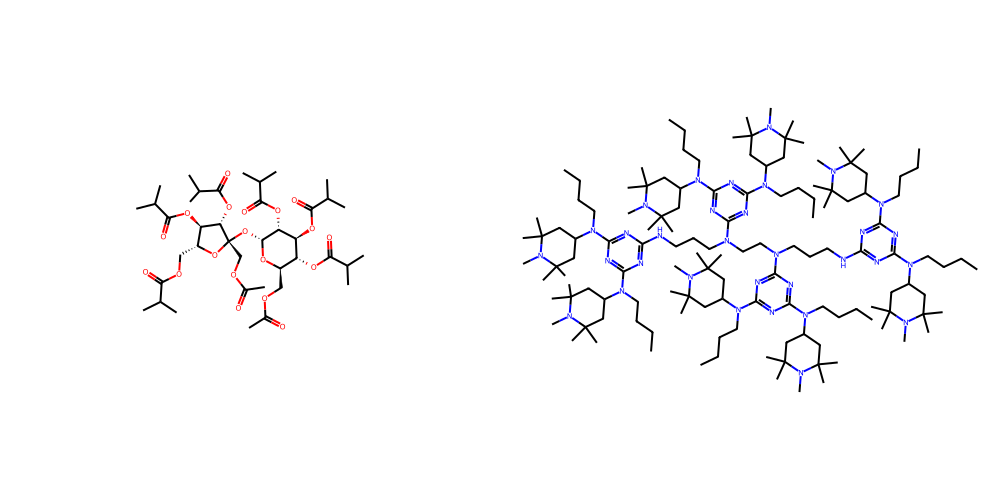

In [33]:
should_have_been_registered_smiles = set(df_original_298_dup_dropped_smiles) - set(df_cleaned_smiles)
should_have_been_registered_mols = [Chem.MolFromSmiles(smile) for smile in should_have_been_registered_smiles]
Draw.MolsToGridImage(should_have_been_registered_mols, molsPerRow=2, subImgSize=(500,500))

The issue with these, was that conformer generation failed because of initial coords:

In [34]:
from rdkit.Chem import rdDistGeom

def print_failure_causes(counts):
    for i,k in enumerate(rdDistGeom.EmbedFailureCauses.names):
        print(k,counts[i])

ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.trackFailures = True
for smi in should_have_been_registered_smiles:
    mol = Chem.AddHs(Chem.MolFromSmiles(smi, sanitize=False))
    ps = rdDistGeom.ETKDGv3()
    ps.randomSeed = 0xf00d
    ps.trackFailures = True
    print(rdDistGeom.EmbedMolecule(mol, ps))
    counts = ps.GetFailureCounts()
    print('\n---------------------------\n')
    print_failure_causes(counts)
    print('\n---------------------------\n')

-1

---------------------------

INITIAL_COORDS 1210
FIRST_MINIMIZATION 0
CHECK_TETRAHEDRAL_CENTERS 0
CHECK_CHIRAL_CENTERS 0
MINIMIZE_FOURTH_DIMENSION 0
ETK_MINIMIZATION 0
FINAL_CHIRAL_BOUNDS 0
FINAL_CENTER_IN_VOLUME 0
LINEAR_DOUBLE_BOND 0
BAD_DOUBLE_BOND_STEREO 0

---------------------------

-1

---------------------------

INITIAL_COORDS 4140
FIRST_MINIMIZATION 0
CHECK_TETRAHEDRAL_CENTERS 0
CHECK_CHIRAL_CENTERS 0
MINIMIZE_FOURTH_DIMENSION 0
ETK_MINIMIZATION 0
FINAL_CHIRAL_BOUNDS 0
FINAL_CENTER_IN_VOLUME 0
LINEAR_DOUBLE_BOND 0
BAD_DOUBLE_BOND_STEREO 0

---------------------------



However, a simple fix is to just to use random coords

In [36]:
from rdkit.Chem import rdDistGeom

def print_failure_causes(counts):
    for i,k in enumerate(rdDistGeom.EmbedFailureCauses.names):
        print(k,counts[i])
mols_3d = []
ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.trackFailures = True
for smi in should_have_been_registered_smiles:
    mol = Chem.AddHs(Chem.MolFromSmiles(smi, sanitize=False))
    ps = rdDistGeom.ETKDGv3()
    ps.randomSeed = 0xf00d
    ps.trackFailures = True
    ps.useRandomCoords = True
    print(rdDistGeom.EmbedMolecule(mol, ps))
    counts = ps.GetFailureCounts()
    print('\n---------------------------\n')
    print_failure_causes(counts)
    print('\n---------------------------\n')
    mols_3d.append(mol)

0

---------------------------

INITIAL_COORDS 0
FIRST_MINIMIZATION 0
CHECK_TETRAHEDRAL_CENTERS 0
CHECK_CHIRAL_CENTERS 0
MINIMIZE_FOURTH_DIMENSION 0
ETK_MINIMIZATION 0
FINAL_CHIRAL_BOUNDS 1
FINAL_CENTER_IN_VOLUME 0
LINEAR_DOUBLE_BOND 0
BAD_DOUBLE_BOND_STEREO 0

---------------------------

0

---------------------------

INITIAL_COORDS 0
FIRST_MINIMIZATION 0
CHECK_TETRAHEDRAL_CENTERS 0
CHECK_CHIRAL_CENTERS 0
MINIMIZE_FOURTH_DIMENSION 0
ETK_MINIMIZATION 0
FINAL_CHIRAL_BOUNDS 0
FINAL_CENTER_IN_VOLUME 0
LINEAR_DOUBLE_BOND 0
BAD_DOUBLE_BOND_STEREO 0

---------------------------



In [38]:
#now we need to register these two mols, and run the simulations.
import lwreg
from lwreg import standardization_lib
from lwreg import utils
config = lwreg.utils.defaultConfig()
# set the name of the database we'll work with:
config['dbtype'] = 'postgresql'
config['dbname'] = 'cs_mdfps'
config['host'] = 'lebanon'
config['user'] = 'cschiebroek'
config['password'] = '' # password is saved in our .pgpass
# we don't want to standardize the molecules:
config['standardization'] = standardization_lib.RemoveHs()
# we want to store conformers
config['registerConformers'] = True

In [40]:
lwreg.bulk_register(config=config,mols=mols_3d)

((15648, 15646), (15649, 15647))

In [41]:
#we need to make a special confgen_uuid for these;
import uuid
confgen_uuid = uuid.uuid4()

In [45]:
import json
params = {"randomSeed":0xf00d,"trackFailures":True,"useRandomCoords":True}
params_json = json.dumps(params)

In [46]:
#then register the conf gen metadata
import psycopg2
cn = psycopg2.connect(host='lebanon',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
cur.execute('insert into cs_mdfps_schema.confid_metadata values (%s,%s)',(str(confgen_uuid),str(params_json)))
cn.commit()



In [51]:
#and register the conformers in confid_data
cn = psycopg2.connect(host='lebanon',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
cur.execute('insert into cs_mdfps_schema.confid_data values (%s,%s)',(str(15646),str(confgen_uuid)))
cur.execute('insert into cs_mdfps_schema.confid_data values (%s,%s)',(str(15647),str(confgen_uuid)))
cn.commit()


In [59]:
lwreg.query(config=config,smiles=list(should_have_been_registered_smiles)[0])

[15648]

In [64]:
#add to experimental data
for smile in should_have_been_registered_smiles:
    vp = df_original_298_dup_dropped[df_original_298_dup_dropped['SMILES'] == smile]['Vapour Pressure (log10 kPa)'].tolist()[0]
    temp = df_original_298_dup_dropped[df_original_298_dup_dropped['SMILES'] == smile]['Temperature'].tolist()[0]
    source = df_original_298_dup_dropped[df_original_298_dup_dropped['SMILES'] == smile]['Source'].tolist()[0]
    vp_log10Pa = vp+3
    molregno = lwreg.query(config=config,smiles=smile)
    molregno = molregno[0]
    logp = 0
    logp_metadata = {}
    metadata = {"SMILES" : smile,"Source" : source,"Temperature" : temp}
    print(molregno,logp,logp_metadata,vp_log10Pa,metadata)
    cur.execute('insert into cs_mdfps_schema.experimental_data values (%s , %s, %s, %s, %s)',(str(molregno),str(0),json.dumps({}),str(vp_log10Pa),json.dumps(metadata)))



15648 0 {} -5.585026652029182 {'SMILES': '[CH3]-[C](=[O])-[O]-[CH2]-[C@H]1-[O]-[C@H](-[O]-[C@]2(-[CH2]-[O]-[C](-[CH3])=[O])-[O]-[C@H](-[CH2]-[O]-[C](=[O])-[CH](-[CH3])-[CH3])-[C@@H](-[O]-[C](=[O])-[CH](-[CH3])-[CH3])-[C@@H]-2-[O]-[C](=[O])-[CH](-[CH3])-[CH3])-[C@H](-[O]-[C](=[O])-[CH](-[CH3])-[CH3])-[C@@H](-[O]-[C](=[O])-[CH](-[CH3])-[CH3])-[C@@H]-1-[O]-[C](=[O])-[CH](-[CH3])-[CH3]', 'Source': 'REACH', 'Temperature': 298.15}
15649 0 {} -10.017728766960431 {'SMILES': '[CH3]-[CH2]-[CH2]-[CH2]-[N](-[c]1:[n]:[c](-[NH]-[CH2]-[CH2]-[CH2]-[N](-[CH2]-[CH2]-[N](-[CH2]-[CH2]-[CH2]-[NH]-[c]2:[n]:[c](-[N](-[CH2]-[CH2]-[CH2]-[CH3])-[CH]3-[CH2]-[C](-[CH3])(-[CH3])-[N](-[CH3])-[C](-[CH3])(-[CH3])-[CH2]-3):[n]:[c](-[N](-[CH2]-[CH2]-[CH2]-[CH3])-[CH]3-[CH2]-[C](-[CH3])(-[CH3])-[N](-[CH3])-[C](-[CH3])(-[CH3])-[CH2]-3):[n]:2)-[c]2:[n]:[c](-[N](-[CH2]-[CH2]-[CH2]-[CH3])-[CH]3-[CH2]-[C](-[CH3])(-[CH3])-[N](-[CH3])-[C](-[CH3])(-[CH3])-[CH2]-3):[n]:[c](-[N](-[CH2]-[CH2]-[CH2]-[CH3])-[CH]3-[CH2]-[C](-[CH3])(-

In [65]:
cn.commit()

'\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 59 60 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C -1.655317 0.513235 -6.625435 0\nM  V30 2 C -1.757634 0.391789 -5.125833 0\nM  V30 3 O -1.674959 1.469029 -4.469759 0\nM  V30 4 O -1.929251 -0.808249 -4.501534 0\nM  V30 5 C -2.023509 -0.957781 -3.114649 0\nM  V30 6 C -0.768151 -0.501807 -2.455320 0 CFG=1\nM  V30 7 O -0.809677 -0.626254 -1.065585 0\nM  V30 8 C 0.476162 -0.592273 -0.525613 0 CFG=2\nM  V30 9 O 0.323406 -0.040454 0.753731 0\nM  V30 10 C 0.703928 -0.983635 1.736754 0 CFG=2\nM  V30 11 C 2.177242 -1.200399 1.683050 0\nM  V30 12 O 2.604901 -2.151671 2.671137 0\nM  V30 13 C 3.967765 -2.428689 2.706363 0\nM  V30 14 C 4.578462 -3.383823 3.660755 0\nM  V30 15 O 4.753982 -1.858479 1.902006 0\nM  V30 16 O -0.064079 -2.117731 1.651510 0\nM  V30 17 C -0.817962 -2.250112 2.768862 0 CFG=2\nM  V30 18 C -2.059320 -3.061824 2.619355 0\nM  V30 19 O -2.957613 -2.567612 1.674587 0\nM  V30 20 C -4.14

In [73]:
for mol in mols_3d:
    query = lwreg.query(config=config,mol=mol)
    confid = query[0][1]
    hits = lwreg.retrieve(config=config,ids=query)
    mb = hits[0][2]
    print(mb,file=open(f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data/mols_3d/{confid}.mol','w+'))  

[(15648, 15646)]
15646

     RDKit          3D

  0  0  0  0  0  0  0  0  0  0999 V3000
M  V30 BEGIN CTAB
M  V30 COUNTS 59 60 0 0 0
M  V30 BEGIN ATOM
M  V30 1 C -1.655317 0.513235 -6.625435 0
M  V30 2 C -1.757634 0.391789 -5.125833 0
M  V30 3 O -1.674959 1.469029 -4.469759 0
M  V30 4 O -1.929251 -0.808249 -4.501534 0
M  V30 5 C -2.023509 -0.957781 -3.114649 0
M  V30 6 C -0.768151 -0.501807 -2.455320 0 CFG=1
M  V30 7 O -0.809677 -0.626254 -1.065585 0
M  V30 8 C 0.476162 -0.592273 -0.525613 0 CFG=2
M  V30 9 O 0.323406 -0.040454 0.753731 0
M  V30 10 C 0.703928 -0.983635 1.736754 0 CFG=2
M  V30 11 C 2.177242 -1.200399 1.683050 0
M  V30 12 O 2.604901 -2.151671 2.671137 0
M  V30 13 C 3.967765 -2.428689 2.706363 0
M  V30 14 C 4.578462 -3.383823 3.660755 0
M  V30 15 O 4.753982 -1.858479 1.902006 0
M  V30 16 O -0.064079 -2.117731 1.651510 0
M  V30 17 C -0.817962 -2.250112 2.768862 0 CFG=2
M  V30 18 C -2.059320 -3.061824 2.619355 0
M  V30 19 O -2.957613 -2.567612 1.674587 0
M  V30 20 C -4.147893

In [74]:
#now for the diverse conformer generation.
mols_3d_100_confs = []
etkdg = rdDistGeom.ETKDGv3()
etkdg.randomSeed = 0xa700f
etkdg.verbose = False
etkdg.numThreads = 4
etkdg.trackFailures = True
etkdg.useRandomCoords = True
etkdg.pruneRmsThresh = 0.1
for smi in should_have_been_registered_smiles:
    m = Chem.MolFromSmiles(smi)
    m = Chem.AddHs(m)
    rdDistGeom.EmbedMultipleConfs(m,numConfs = 100, params = etkdg)
    print(m.GetNumConformers())
    mols_3d_100_confs.append(m)


100
100


In [75]:
#to pick the five most diverse conformers, we will use the rdkit MaxMinPicker based on RMS.
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.SimDivFilters import rdSimDivPickers

picker = rdSimDivPickers.MaxMinPicker()

def pick_conformers(mol,picks):
    def custom_rmsd_distance(i, j):
        return AllChem.GetBestRMS(mol,mol,i,j)
    selected_indices = list(picker.LazyPick(custom_rmsd_distance, mol.GetNumConformers(), picks, seed=1966))
    mol_X_confs = Chem.Mol(mol)
    mol_X_confs.RemoveAllConformers()
    for i in selected_indices:
        mol_X_confs.AddConformer(mol.GetConformer(i))
    return mol_X_confs

In [76]:
from tqdm import tqdm
selected_confs_mol_list = []
for mol in tqdm(mols_3d_100_confs):
    mol = Chem.RemoveHs(mol)   #we remove the hydrogens to prevent a combinatory explostion when calculating the RMSD
    picked_mol = pick_conformers(mol,5)
    selected_confs_mol_list.append(picked_mol)


 50%|█████     | 1/2 [28:01<28:01, 1681.84s/it]


KeyboardInterrupt: 

In [81]:
selected_confs_mol_list[0].GetNumConformers()

5

In [103]:
mol = mols_3d_100_confs[1]
mol = Chem.RemoveHs(mol)   #we remove the hydrogens to prevent a combinatory explostion when calculating the RMSD
picked_mol = pick_conformers(mol,5)
selected_confs_mol_list.append(picked_mol)


In [111]:
len(selected_confs_mol_list)
for mol in selected_confs_mol_list:
    print(mol.GetNumConformers())

5
5


In [104]:
#make a uuid for this confgen
import uuid
confgen_uuid_diverse = uuid.uuid4()

In [106]:
confgen_uuid_diverse

UUID('f02056de-5fe6-410f-9b7c-c34817821b54')

In [112]:
from tqdm import tqdm
with Chem.SDWriter(f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data/confgen/{confgen_uuid_diverse}/{confgen_uuid_diverse}_5.sdf') as w:
    for mol in tqdm(selected_confs_mol_list):
        cids = [conf.GetId() for conf in mol.GetConformers()]
        for cid in cids:
            w.write(mol,confId=cid)

100%|██████████| 2/2 [00:00<00:00, 406.78it/s]


In [113]:
mols_five_conf_sup = Chem.SDMolSupplier(f'/localhome/cschiebroek/MDFPs/mdfptools/carl/data/confgen/{confgen_uuid_diverse}/{confgen_uuid_diverse}_5.sdf',removeHs=False)
mols_five_conf = [mol for mol in mols_five_conf_sup]
print(len(mols_five_conf))

10


In [115]:
lwreg.bulk_register(config=config, mols=mols_five_conf)

((15648, 15648),
 (15648, 15649),
 (15648, 15650),
 (15648, 15651),
 (15648, 15652),
 (15649, 15653),
 (15649, 15654),
 (15649, 15655),
 (15649, 15656),
 (15649, 15657))

Simulation for single conformer is running, but seems that the molecules are too big to simulate in our current workflow

lastly, we need to to remove the duplicates we have registered, from:
- conformers
- confid_data
- experimental_data
- mdfp_experiment_data

In [86]:
smiles_to_remove = set(df_cleaned_smiles) - set(df_original_298_dup_dropped_smiles)


In [84]:
cn = psycopg2.connect(host='lebanon',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
cur.execute('select * from cs_mdfps_schema.experimental_data')
all_data = cur.fetchall()

In [87]:
#put this into a dataframe
import pandas as pd
df = pd.DataFrame(all_data,columns=['molregno','logp','logp_metadata','vp_log10Pa','metadata'])
#from the metadata, we can get the smiles
df['smiles'] = df['metadata'].apply(lambda x: x['SMILES'])
df_to_remove = df[df['smiles'].isin(smiles_to_remove)]
df_to_remove

,molregno,logp,logp_metadata,vp_log10Pa,metadata,smiles
356,326,0,{},4.030098,"{'SMILES': '[CH3]/[CH]=[C](/[CH3])-[Br]', 'Sou...",[CH3]/[CH]=[C](/[CH3])-[Br]
403,373,0,{},1.141935,{'SMILES': '[CH3]-[C](=[O])-[O]-[CH]1-[CH2]-[C...,[CH3]-[C](=[O])-[O]-[CH]1-[CH2]-[CH](-[CH3])-[...
494,464,0,{},1.937815,{'SMILES': '[CH3]-[C]12-[CH2]-[CH2]-[CH](-[CH2...,[CH3]-[C]12-[CH2]-[CH2]-[CH](-[CH2]-[C]-1=[O])...
537,507,0,{},0.643416,{'SMILES': '[CH3]-[C](=[O])-[O]-[CH2]/[CH]=[C]...,[CH3]-[C](=[O])-[O]-[CH2]/[CH]=[C](/[CH3])-[CH...
908,877,0,{},1.278754,{'SMILES': '[CH3]-[CH](-[CH3])-[C@@H]1-[CH2]-[...,[CH3]-[CH](-[CH3])-[C@@H]1-[CH2]-[CH2]-[C@@H](...
1112,2236,0,{},1.414973,{'SMILES': '[CH3]-[C](=[O])-[O]-[C@H]1-[CH2]-[...,[CH3]-[C](=[O])-[O]-[C@H]1-[CH2]-[C@@H](-[CH3]...
1140,2265,0,{},3.345618,"{'SMILES': '[Cl]-[CH2]-[CH]1-[CH2]-[O]-1', 'So...",[Cl]-[CH2]-[CH]1-[CH2]-[O]-1
1392,2520,0,{},3.041393,"{'SMILES': '[Cl]-[CH2]-[C@@H]1-[CH2]-[O]-1', '...",[Cl]-[CH2]-[C@@H]1-[CH2]-[O]-1
1422,2545,0,{},1.612040,"{'SMILES': '[I]/[CH]=[CH]\[I]', 'Source': 298....",[I]/[CH]=[CH]\[I]
1451,2559,0,{},3.930729,{'SMILES': '[CH3]-[C@@H]1-[CH2]-[CH2]-[CH2]-[C...,[CH3]-[C@@H]1-[CH2]-[CH2]-[CH2]-[C@H]-1-[CH3]


In [91]:
molregnos_to_remove = df_to_remove['molregno'].tolist()

In [94]:
len(molregnos_to_remove)

26

In [93]:
#and get the confids
hits_to_remove = lwreg.query(config=config,ids=molregnos_to_remove)
hits_to_remove
confids_to_remove = [hit[1] for hit in hits_to_remove]  

In [95]:
#1. drop from table experimental data
cn = psycopg2.connect(host='lebanon',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
cur.execute('delete from cs_mdfps_schema.experimental_data where molregno in %s',(tuple(molregnos_to_remove),))
cn.commit()


In [96]:
#check with count how many are left
cur.execute('select count(*) from cs_mdfps_schema.experimental_data')
cur.fetchall()


[(3042,)]

In [97]:
print(len(confids_to_remove))

134


In [99]:
#drop the conformers from confid_data
cn = psycopg2.connect(host='lebanon',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
cur.execute('delete from cs_mdfps_schema.confid_data where conf_id in %s',(tuple(confids_to_remove),))
cn.commit()

In [100]:
#remove from conformers
cn = psycopg2.connect(host='lebanon',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
cur.execute('delete from public.conformers where conf_id in %s',(tuple(confids_to_remove),))
cn.commit()

In [102]:
#remove from mdfp_experiment_data
cn = psycopg2.connect(host='lebanon',dbname='cs_mdfps',user='cschiebroek')
cur = cn.cursor()
cur.execute('delete from cs_mdfps_schema.mdfp_experiment_data where conf_id in %s',(tuple(confids_to_remove),))
cn.commit()
